# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [7]:
class_names = ['brb1', 'brb2', 'brb3', 'brb4', 'Healthy']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)
Input_size=IMAGE_SIZE

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [4]:
def load_data():
    
    datasets = ['/kaggle/input/vib255/DTT_VIB/Train', '/kaggle/input/vib255/DTT_VIB/Test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /kaggle/input/vib255/DTT_VIB/Train


100%|██████████| 6000/6000 [00:56<00:00, 105.93it/s]


In [55]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Let's explore the dataset
We can ask ourselves:
* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [56]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1396
Number of testing examples: 595
Each image is of size: (224, 224)


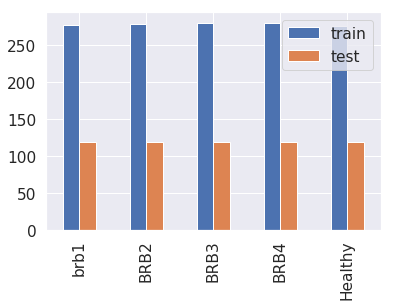

In [57]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

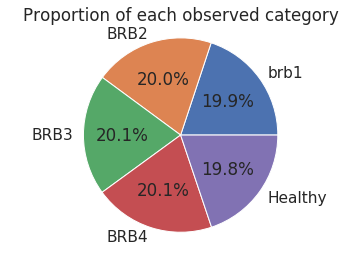

In [58]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [59]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [60]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

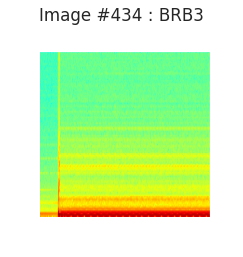

In [61]:
display_random_image(class_names, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [62]:
def display_examples(class_names, images, labels):
    
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

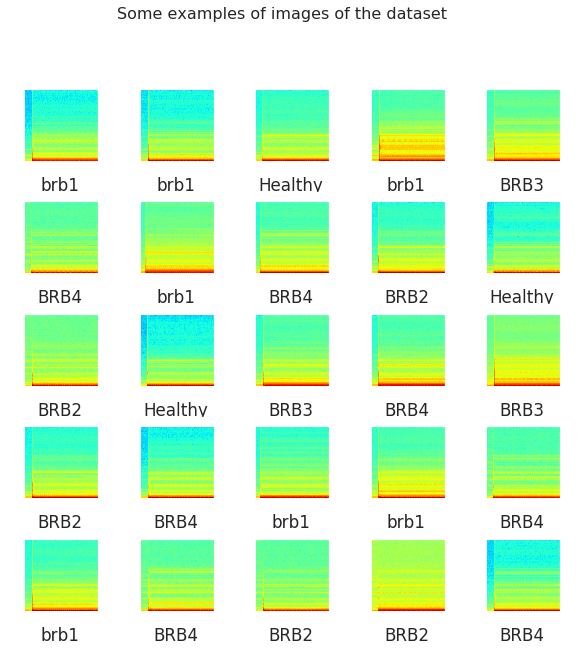

In [63]:
display_examples(class_names, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [ ]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (224,224, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
          
model.add(Dense(num_classes, activation='softmax'))

In [69]:
import tensorflow as tf

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(0.5),  # Add dropout layer with 50% dropout rate
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])


Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [70]:
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [71]:

# Train the model and use the defined callback
history = model1.fit(train_images, train_labels, batch_size=32, epochs=50,
                     validation_split=0.2)


Train on 1116 samples, validate on 280 samples
Epoch 1/50
1116/1116 [==============================] - 2s 2ms/sample - loss: 12.6681 - acc: 0.1935 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 2/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 3/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 4/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 5/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 6/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val_acc: 0.2107
Epoch 7/50
1116/1116 [==============================] - 1s 1ms/sample - loss: 12.9118 - acc: 0.1989 - val_loss: 12.7218 - val

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

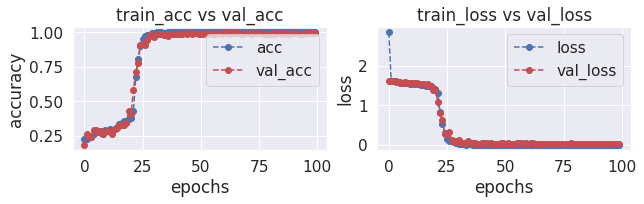

In [26]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [27]:
test_loss = model.evaluate(test_images, test_labels)

595/595 [==============================] - 0s 580us/sample - loss: 1.6866 - acc: 0.7697


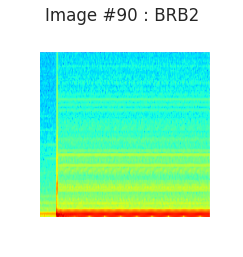

In [28]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [43]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


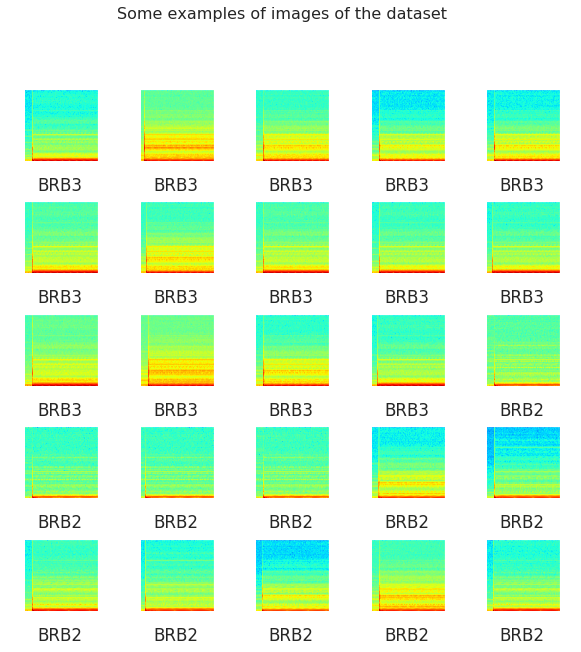

In [44]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

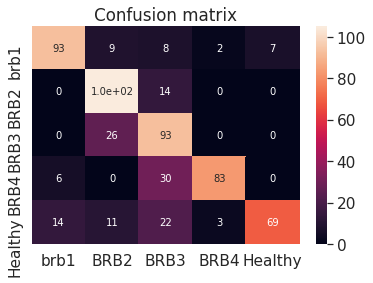

In [45]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

### VGG16

In [16]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


Using TensorFlow backend.


In [17]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded format
train_labels = to_categorical(train_labels, nb_classes)
test_labels = to_categorical(test_labels, nb_classes)


In [18]:

# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3))
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 3s 0us/step


In [19]:


# Create the custom top layers for 5-class classification
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(5, activation='softmax'))

# Compile the model
model2.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])






In [20]:
# Train the model and use the defined callback
history = model2.fit(train_images, train_labels, batch_size=32, epochs=100,
                     validation_split=0.2)


Instructions for updating:
Use tf.cast instead.
Train on 1116 samples, validate on 280 samples
Epoch 1/100
1116/1116 [==============================] - 9s 8ms/step - loss: 1.7195 - acc: 0.2625 - val_loss: 1.4904 - val_acc: 0.4143
Epoch 2/100
1116/1116 [==============================] - 4s 3ms/step - loss: 1.4355 - acc: 0.3889 - val_loss: 1.5061 - val_acc: 0.3286
Epoch 3/100
1116/1116 [==============================] - 4s 3ms/step - loss: 1.3263 - acc: 0.4955 - val_loss: 1.4140 - val_acc: 0.4179
Epoch 4/100
1116/1116 [==============================] - 4s 3ms/step - loss: 1.2296 - acc: 0.5358 - val_loss: 1.2573 - val_acc: 0.5321
Epoch 5/100
1116/1116 [==============================] - 4s 3ms/step - loss: 1.0905 - acc: 0.6443 - val_loss: 1.1607 - val_acc: 0.5429
Epoch 6/100
1116/1116 [==============================] - 4s 3ms/step - loss: 1.0298 - acc: 0.6443 - val_loss: 1.1065 - val_acc: 0.6071
Epoch 7/100
1116/1116 [==============================] - 4s 3ms/step - loss: 0.9680 - acc: 0.66

In [29]:

model2.save('VGG16l.h5')


In [21]:
test_loss = model2.evaluate(test_images, test_labels)
print("VGG16 TESTING ACCURACY :",test_loss[1])

595/595 [==============================] - 2s 3ms/step
VGG16 TESTING ACCURACY : 0.7915966390561657


In [24]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [26]:
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D

In [27]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the training labels
train_labels_one_hot = to_categorical(train_labels, num_classes=5)

# ... (Rest of your code)




In [28]:
# Load the pre-trained MobileNetV2 model without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(5, activation="softmax")
])

model3.layers[0].trainable = False

# Compile the model
model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and use the defined callback
history2 = model3.fit(train_images, train_labels, batch_size=32, epochs=200, validation_split=0.2)


9412608/9406464 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1116 samples, validate on 280 samples
Epoch 1/200
1116/1116 [==============================] - 4s 4ms/sample - loss: 2.0819 - acc: 0.2643 - val_loss: 1.9427 - val_acc: 0.2179
Epoch 2/200
1116/1116 [==============================] - 2s 1ms/sample - loss: 1.5272 - acc: 0.3835 - val_loss: 2.0262 - val_acc: 0.2000
Epoch 3/200
1116/1116 [==============================] - 2s 1ms/sample - loss: 1.1976 - acc: 0.5287 - val_loss: 2.0868 - val_acc: 0.1964
Epoch 4/200
1116/1116 [==============================] - 2s 2ms/sample - loss: 1.0313 - acc: 0.6013 - val_loss: 2.2121 - val_acc: 0.2321
Epoch 5/200
1116/1116 [==============================] - 2s 1ms/sample - loss: 0.8738 - acc: 0.6801 - val_loss: 2.4185 - val_acc: 0.2321
Epoch 6/200
1116/1116 [==============================] - 2s 1ms/sample - loss: 0.7415 - ac

In [30]:
test_loss = model3.evaluate(test_images, test_labels)


595/595 [==============================] - 1s 2ms/sample - loss: 2.6135 - acc: 0.4605


In [31]:
model3.save("mobilenet.h5")

# inceptionV3

In [7]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class_names = ['brb1', 'BRB2', 'BRB3', 'BRB4', 'Healthy']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)
Input_size = IMAGE_SIZE

(train_images, train_labels), (test_images, test_labels) = load_data()

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoded format
train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

# Load the pre-trained InceptionV3 model without the top classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the custom top layers for 5-class classification
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model and use the defined callback
history = model.fit(train_images, train_labels, batch_size=16,
                    epochs=100, validation_split=0.2)


  8%|▊         | 23/279 [00:00<00:01, 225.34it/s]

Loading /kaggle/input/images/dataset/train


 14%|█▍        | 17/119 [00:00<00:00, 165.16it/s]

Loading /kaggle/input/images/dataset/testing


100%|██████████| 119/119 [00:00<00:00, 217.29it/s]


Number of training examples: 1396
Number of testing examples: 595
Each image is of size: (224, 224)
Train on 1116 samples, validate on 280 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1116/1116 [==============================] - 9s 8ms/sample - loss: 1.7343 - acc: 0.3638 - val_loss: 1.8544 - val_acc: 0.2500
Epoch 2/100
1116/1116 [==============================] - 4s 3ms/sample - loss: 0.9385 - acc: 0.6470 - val_loss: 1.9939 - val_acc: 0.2143
Epoch 3/100
1116/1116 [==============================] - 4s 4ms/sample - loss: 0.6811 - acc: 0.7518 - val_loss: 2.0158 - val_acc: 0.2107
Epoch 4/100
1116/1116 [==============================] - 4s 3ms/sample - loss: 0.5244 - acc: 0.8082 - val_loss: 2.0789 - val_acc: 0.2357
Epoch 5/100
1116/1116 [==============================] - 4s 3ms/sample - loss: 0.3524 - acc: 0.8925 - val_loss: 2.0775 - val_acc: 0.2500
Epoch 6/100
1116/1116 [==============================] - 4s 4ms/sample - loss: 0.2516 - acc: 0.9274 - val_loss: 2.9132 -

In [8]:
model.save("inceptionv33.h5")

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Configure TensorFlow to use GPU memory growth

# Define paths to your dataset
train_data_dir = '/kaggle/input/vib255/DTT_VIB/Train'
test_data_dir = '/kaggle/input/vib255/DTT_VIB/Test'
validation_data_dir = '/kaggle/input/vib255/DTT_VIB/Val'

In [4]:


# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data normalization for testing and validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 30000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [5]:


# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
938/938 [==============================] - 730s 778ms/step - loss: 1.3696 - acc: 0.3743 - val_loss: 1.0887 - val_acc: 0.5250
Epoch 2/20
 52/938 [>.............................] - ETA: 7:04 - loss: 1.1530 - acc: 0.4772

KeyboardInterrupt: 

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Configure TensorFlow to use GPU memory growth


train_data_dir = '/kaggle/input/vib255/DTT_VIB/Train'
test_data_dir = '/kaggle/input/vib255/DTT_VIB/Test'
validation_data_dir = '/kaggle/input/vib255/DTT_VIB/Val'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data normalization for testing and validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(5, activation='softmax')
# ])




model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer with 50% dropout rate
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])















# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Found 30000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Epoch 1/20
535/938 [================>.............] - ETA: 4:06 - loss: 1.5193 - acc: 0.2870

KeyboardInterrupt: 

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Configure TensorFlow to use GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Print available GPUs
print("Available GPUs:", tf.config.experimental.list_physical_devices('GPU'))


AttributeError: module 'tensorflow' has no attribute 'config'

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Explicitly allow GPU memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Print available GPUs
print("Available GPUs:", tf.test.gpu_device_name())

Available GPUs: /device:GPU:0


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Explicitly allow GPU memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Print available GPUs
print("Available GPUs:", tf.test.gpu_device_name())

# Define paths to your dataset
train_data_dir = '/kaggle/input/vib255/DTT_VIB/Train'
test_data_dir = '/kaggle/input/vib255/DTT_VIB/Test'
validation_data_dir = '/kaggle/input/vib255/DTT_VIB/Val'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data normalization for testing and validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare the validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Available GPUs: /device:GPU:0
Found 30000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Epoch 1/20
938/938 [==============================] - 816s 870ms/step - loss: 1.3194 - acc: 0.3881 - val_loss: 0.8945 - val_acc: 0.6023
Epoch 2/20
938/938 [==============================] - 754s 804ms/step - loss: 0.9528 - acc: 0.5842 - val_loss: 0.9407 - val_acc: 0.6616
Epoch 3/20
938/938 [==============================] - 747s 797ms/step - loss: 0.7989 - acc: 0.6633 - val_loss: 1.1062 - val_acc: 0.6676
Epoch 4/20
938/938 [==============================] - 748s 797ms/step - loss: 0.7168 - acc: 0.7041 - val_loss: 0.5924 - val_acc: 0.7809
Epoch 5/20
938/938 [==============================] - 748s 798ms/step - loss: 0.6598 - acc: 0.7291 - val_loss: 0.6742 - val_acc: 0.7580
Epoch 6/20
938/938 [==============================] - 755s 805ms/step - loss: 0.6173 - acc: 0.7470 - val_loss: 0.6482 - val_acc: 0.7706
Epoch 7/20
938/938 [=====

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set paths to your training and validation directories
train_dir = '/kaggle/input/vib255/DTT_VIB/Train'
val_dir = '/kaggle/input/vib255/DTT_VIB/Val'

# List of class names (subfolder names)
class_names = os.listdir(train_dir)

# Initialize empty lists to store images, labels, and encodings
train_images = []
train_labels = []
val_images = []
val_labels = []

# Load training images and labels
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(class_dir, filename)
            img = imread(img_path)
            img = resize(img, (224, 224))  # Resize images to a common size
            train_images.append(img)
            train_labels.append(class_name)

# Load validation images and labels
for class_name in class_names:
    class_dir = os.path.join(val_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(class_dir, filename)
            img = imread(img_path)
            img = resize(img, (224, 224))  # Resize images to a common size
            val_images.append(img)
            val_labels.append(class_name)

# Convert lists to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
X_val = np.array(val_images)
y_val = np.array(val_labels)

# Flatten and normalize the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Initialize and train the KNN classifier
k = 5  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_flat, y_train_encoded)

# Make predictions on the validation set
y_pred_encoded = knn_classifier.predict(X_val_flat)

# Decode encoded predictions
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
